In [1]:
import cv2
import glob
import random
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models as sm

from tqdm import tqdm
from dataset import Dataset
from dataset import visualize
from dataset import Dataloader
from dataset import denormalize
from keras.models import load_model
from segmentation_models.losses import DiceLoss
from segmentation_models.losses import CategoricalFocalLoss
from segmentation_models.metrics import IOUScore
from segmentation_models.metrics import FScore

2023-05-10 15:07:56.239019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


In [2]:
CATEGORY_PATH = "dataset/category_id.txt"
TEST_PATH = "dataset/test/"
TEST_DIRS = glob.glob("dataset/test/*")

MODEL = "fpn-seresnet152"
CHECKPOINT_PATH = "checkpoints/" + MODEL + ".h5"
MODEL_PATH = "models/" + MODEL + ".h5"

THRESHOLD = 0.995

In [3]:
def get_classes():
    categories = pd.read_csv(CATEGORY_PATH, sep="\t", names=["id", "name"])
    # CamVid Dataset
    # ids = categories["id"].to_list()[:-1]
    # classes = categories["name"].to_list()[:-1]
    # FoodSeg103 Dataset
    ids = categories["id"].to_list()[1:]
    classes = categories["name"].to_list()[1:]
    classes = [cls.strip() for cls in classes]
    return ids, classes

In [4]:
def get_val_test_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [A.PadIfNeeded(384, 480)]
    return A.Compose(test_transform)

In [5]:
def get_preprocessing(preprocessing_fn):
    _transform = [A.Lambda(image=preprocessing_fn)]
    return A.Compose(_transform)

In [6]:
preprocess_input = sm.get_preprocessing(MODEL.split("-")[1])

In [7]:
ids, classes = get_classes()

In [8]:
test_dataset = Dataset(TEST_PATH + "img", TEST_PATH + "mask", class_values=ids,
                       augmentation=get_val_test_augmentation(),
                       preprocessing=get_preprocessing(preprocess_input))

In [9]:
test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)
print(test_dataloader[0][0].shape)
print(test_dataloader[0][1].shape)

(1, 384, 480, 3)
(1, 384, 480, 104)


In [10]:
dice_loss = DiceLoss(class_weights=np.append(np.ones(len(get_classes()[0])), 0.5))
focal_loss = CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
iou_score = IOUScore(threshold=0.5)
f1_score = FScore(threshold=0.5)

In [11]:
custom_objects = {
    "iou_score": iou_score,
    "f1-score": f1_score,
    "dice_loss_plus_1focal_loss": total_loss
}
model = load_model(CHECKPOINT_PATH, custom_objects=custom_objects)
print("Model Loaded")

2023-05-10 15:08:06.813680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model Loaded


In [12]:
test_score = model.evaluate_generator(test_dataloader)
print("Test Loss: ", test_score[0])
print("Test Mean IoU: ", test_score[1])
print("Test Mean F1: ", test_score[2])

/Users/hjj/opt/anaconda3/envs/nus-ncs-phishing/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [ ]:
# CamVid Dataset
# image, mask = test_dataset[0]
# visualize(image=image,
#           sky_mask=mask[..., 0].squeeze(),
#           car_mask=mask[..., 8].squeeze(),
#           pedestrian_mask=mask[..., 9].squeeze(),
#           unlabelled_mask=mask[..., 11].squeeze())

In [ ]:
# CamVid Dataset
# n = 5
# ids = np.random.choice(np.arange(len(test_dataset)), size=n)
# for i in ids:
#     image, gt_mask = test_dataset[i]
#     image = np.expand_dims(image, axis=0)
#     pr_mask = model.predict(image)
#     visualize(
#         image=denormalize(image.squeeze()),
#         gt_sky_mask=gt_mask[..., 0].squeeze(),
#         pr_sky_mask=pr_mask[..., 0].squeeze(),
#         gt_car_mask=gt_mask[..., 8].squeeze(),
#         pr_car_mask=pr_mask[..., 8].squeeze())

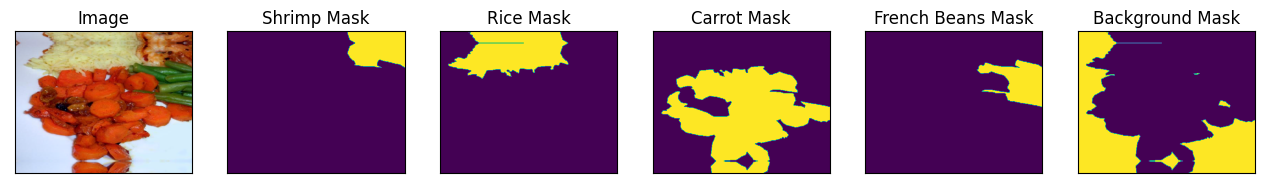

In [13]:
# FoodSeg103 Dataset
image, mask = test_dataset[0]
visualize(image=denormalize(image.squeeze()),
          shrimp_mask=mask[..., 55].squeeze(),
          rice_mask=mask[..., 65].squeeze(),
          carrot_mask=mask[..., 83].squeeze(),
          french_beans_mask=mask[..., 95].squeeze(),
          background_mask=mask[..., 103].squeeze())

1/1 [==============================] - 1s 1s/step


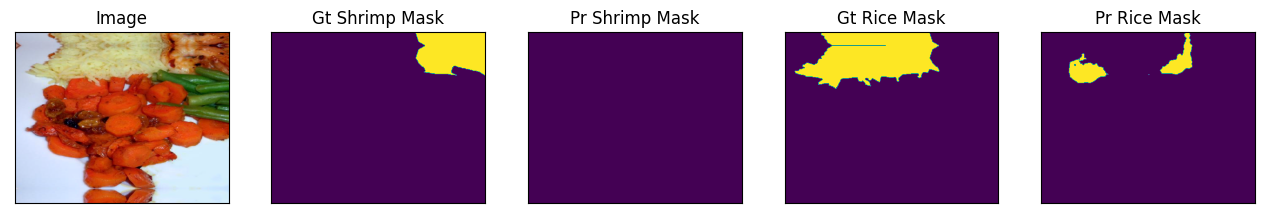

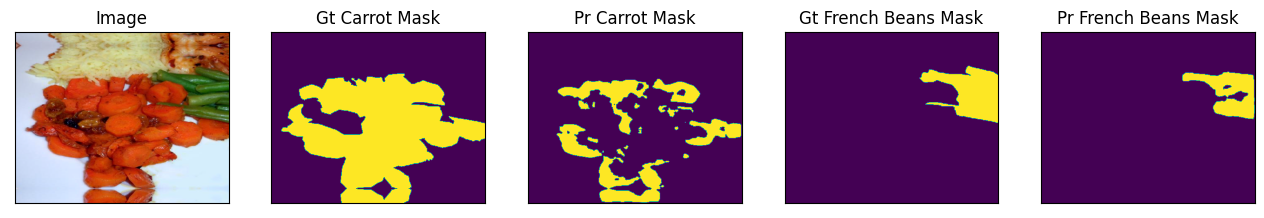

In [14]:
image, gt_mask = test_dataset[0]
image = np.expand_dims(image, axis=0)
pr_mask = np.where((model.predict(image)) < THRESHOLD, 0, 1)
visualize(
    image=denormalize(image.squeeze()),
    gt_shrimp_mask=gt_mask[..., 55].squeeze(),
    pr_shrimp_mask=pr_mask[..., 55].squeeze(),
    gt_rice_mask=gt_mask[..., 65].squeeze(),
    pr_rice_mask=pr_mask[..., 65].squeeze())
visualize(
    image=denormalize(image.squeeze()),
    gt_carrot_mask=gt_mask[..., 83].squeeze(),
    pr_carrot_mask=pr_mask[..., 83].squeeze(),
    gt_french_beans_mask=gt_mask[..., 95].squeeze(),
    pr_french_beans_mask=pr_mask[..., 95].squeeze())

True Labels: ['background', 'egg', 'pork', 'pie', 'tomato', 'lettuce']
1/1 [==============================] - 1s 1s/step
Prediction Labels: ['background', 'egg', 'sauce', 'tomato', 'lettuce']


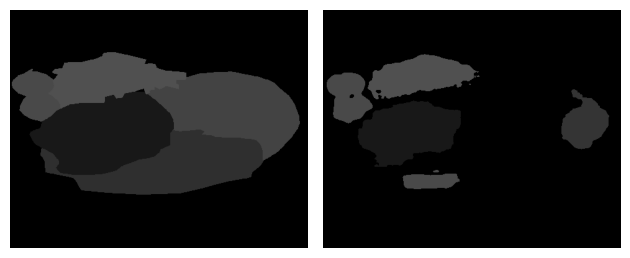

True Labels: ['background', 'wine', 'pork', 'rice', 'broccoli']
1/1 [==============================] - 1s 1s/step
Prediction Labels: ['background', 'blueberry', 'chicken duck', 'sauce', 'rice', 'broccoli']


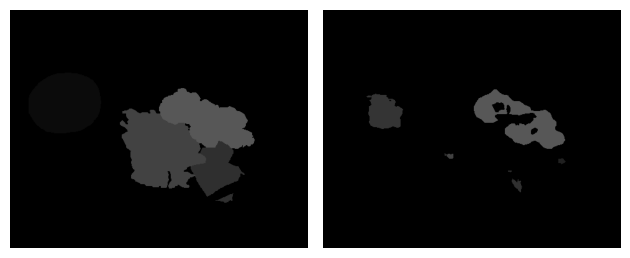

True Labels: ['background', 'chicken duck', 'bread', 'pasta']
1/1 [==============================] - 1s 1s/step
Prediction Labels: ['background', 'bread', 'pasta']


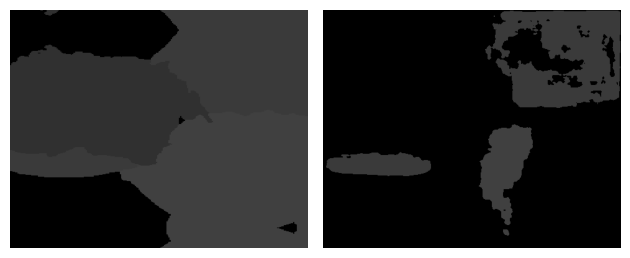

In [15]:
indices = random.sample(range(len(test_dataset)), 3)
for idx in indices:
    image, gt_mask = test_dataset[idx]
    gt_class_indices = []
    gt_img = np.zeros((384, 480))
    for i, idx in enumerate(ids):
        tmp = gt_mask[..., i].squeeze()
        gt_img[tmp == 1] = idx
    unique_channels = np.unique(gt_img)
    true_labels = [classes[ids.index(channel)] if channel > 0 else "background" for channel in unique_channels]
    print("True Labels:", true_labels)
    gt_img = cv2.merge((gt_img, gt_img, gt_img))
    plt.subplot(1, 2, 1)
    plt.imshow(gt_img.astype("uint8"))
    plt.axis("off")

    image = np.expand_dims(image, axis=0)
    pr_mask = np.where((model.predict(image)) < THRESHOLD, 0, 1)
    pr_class_indices = []
    pr_img = np.zeros((384, 480))
    for i, idx in enumerate(ids):
        tmp = pr_mask[..., i].squeeze()
        pr_img[tmp == 1] = idx
    unique_channels = np.unique(pr_img)
    pr_labels = [classes[ids.index(channel)] if channel > 0 else "background" for channel in unique_channels]
    print("Prediction Labels:", pr_labels)
    pr_img = cv2.merge((pr_img, pr_img, pr_img))
    plt.subplot(1, 2, 2)
    plt.imshow(pr_img.astype("uint8"))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [16]:
def count_common_values(arr1, arr2):
    count = 0
    for val in arr1:
        if val in arr2:
            count += 1
    return count

In [17]:
recall = 0
precision = 0

with tqdm(total=len(test_dataset)) as pbar:
    for i, (image, gt_mask) in enumerate(test_dataset):
        pbar.set_description("Predicting: %d" % (1 + i))
        pbar.update(1)
        gt_class_indices = []
        gt_img = np.zeros((384, 480))
        for j, idx in enumerate(ids):
            tmp = gt_mask[..., j].squeeze()
            gt_img[tmp == 1] = idx
        unique_channels = np.unique(gt_img)
        true_labels = [classes[ids.index(channel)] if channel > 0 else "background" for channel in unique_channels]
        if "background" in true_labels:
            true_labels.remove("background")

        image = np.expand_dims(image, axis=0)
        pr_mask = np.where((model.predict(image, verbose=0)) < THRESHOLD, 0, 1)
        pr_class_indices = []
        pr_img = np.zeros((384, 480))
        for j, idx in enumerate(ids):
            tmp = pr_mask[..., j].squeeze()
            pr_img[tmp == 1] = idx
        unique_channels = np.unique(pr_img)
        pr_labels = [classes[ids.index(channel)] if channel > 0 else "background" for channel in unique_channels]
        if "background" in true_labels:
            true_labels.remove("background")

        num_of_common_indices = count_common_values(true_labels, pr_labels)
        # Recall: how many true labels can be found out
        recall = recall + num_of_common_indices / len(true_labels)
        # Precision: how many labels are predicted correctly
        precision = precision + num_of_common_indices / len(pr_labels)

recall = recall / len(test_dataset)
precision = precision / len(test_dataset)
print("Recall:", recall)
print("Precision:", precision)
print("F1:", ((2 * precision * recall) / (precision + recall)))

Predicting: 2135: 100%|███████████████████| 2135/2135 [1:17:22<00:00,  2.17s/it]

Recall: 0.5938390766142508
Precision: 0.4596105078891967
F1: 0.5181732161122404
